# Pneumonia Detection Using CNN Based on X-Ray Images

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import precision_recall_curve

## Loading Dataset

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150 # Image size (150 x 150)

def get_training_data(data_dir):
    data = []  # List to hold image arrays
    labels_list = []  # List to hold labels
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append(resized_arr)  # Append the image array
                labels_list.append(class_num)  # Append the label
            except Exception as e:
                print(e)
    
    # Convert lists into numpy arrays
    data = np.array(data)  # Shape: (num_images, img_size, img_size)
    labels_list = np.array(labels_list)  # Shape: (num_images,)
    
    return data, labels_list

In [3]:
train, train_labels = get_training_data('../input/train')
test, test_labels = get_training_data('../input/test')
val, val_labels = get_training_data('../input/val')

In [4]:
train_labels

array([0, 0, 0, ..., 1, 1, 1])

## Data Visualization & Preprocessing

<Axes: xlabel='count'>

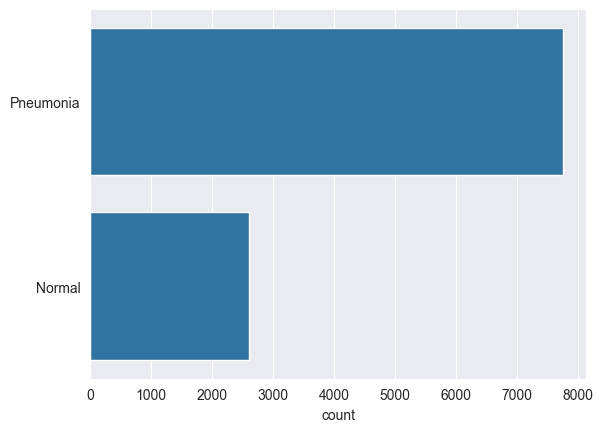

In [5]:
l = []
for i in train_labels:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)   

Text(0.5, 1.0, 'NORMAL')

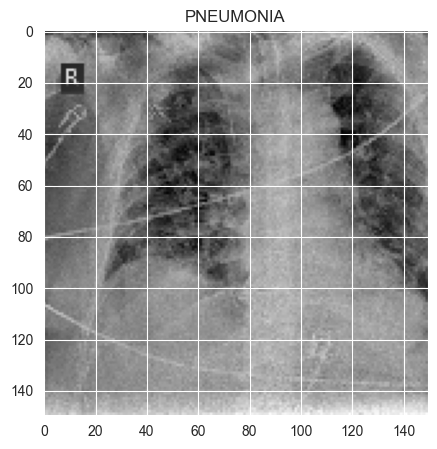

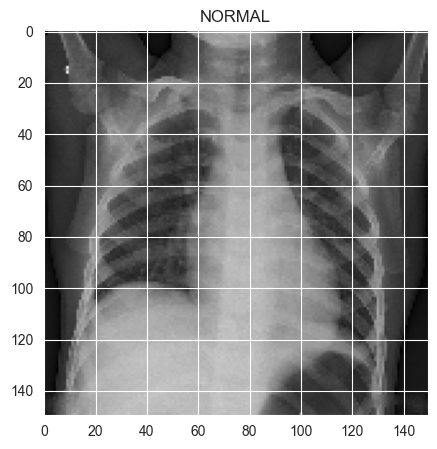

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0], cmap='gray')
plt.title(labels[train_labels[0]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1], cmap='gray')
plt.title(labels[train_labels[-1]])

In [7]:
x_train = train
y_train = train_labels

x_val = val
y_val = val_labels

x_test = test
y_test = test_labels

In [8]:
# Normalize the data
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

In [9]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Data Augmentation

In [10]:
# Separate Class 1 Samples
class_1_indices = np.where(y_train == 1)[0]
x_train_class_1 = x_train[class_1_indices]
y_train_class_1 = y_train[class_1_indices]

# Data Augmentation for Class 1
datagen = ImageDataGenerator(
        featurewise_center=False,               # set input mean to 0 over the dataset
        samplewise_center=False,                # set each sample mean to 0
        featurewise_std_normalization=False,    # divide inputs by std of the dataset
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening
        rotation_range = 30,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,                       # Randomly zoom image 
        width_shift_range=0.1,                  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                 # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,                 # randomly flip images
        vertical_flip=False)                    # randomly flip images

# Define the number of augmented samples you want
num_augmented_samples = len(x_train_class_1) * 2  # For example, twice the number of class 1 samples

# Create an iterator to generate augmented data
augmented_data_iterator = datagen.flow(x_train_class_1, y_train_class_1, batch_size=32)

# Collect augmented samples
x_train_augmented = []
y_train_augmented = []

for _ in range(num_augmented_samples // 32):
    x_batch, y_batch = next(augmented_data_iterator)
    x_train_augmented.append(x_batch)
    y_train_augmented.append(y_batch)

# Concatenate the augmented data
x_train_augmented = np.concatenate(x_train_augmented)
y_train_augmented = np.concatenate(y_train_augmented)

# Combine Augmented Data with Original Data
x_train_combined = np.concatenate([x_train, x_train_augmented], axis=0)
y_train_combined = np.concatenate([y_train, y_train_augmented], axis=0)

# Shuffle the combined data to mix original and augmented samples
shuffle_indices = np.random.permutation(len(y_train_combined))
x_train = x_train_combined[shuffle_indices]
y_train = y_train_combined[shuffle_indices]

In [11]:
print(f"x-train: {x_train.shape}")
print(f"y-train: {x_train.shape}")

x-train: (15527, 150, 150, 1)
y-train: (15527, 150, 150, 1)


<Axes: xlabel='count'>

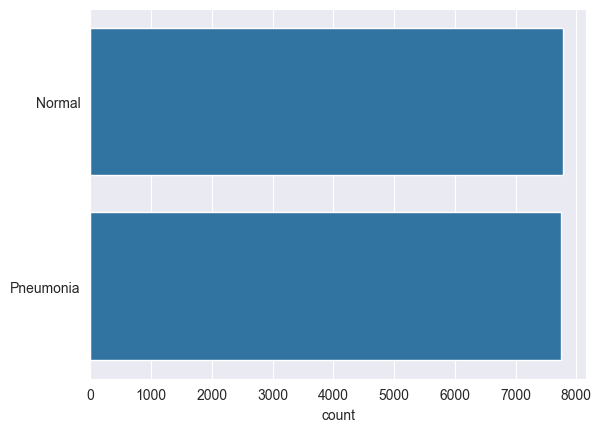

In [12]:
l = []
for i in y_train:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)   

## Model Training

In [13]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [15]:
history = model.fit(x_train, y_train, batch_size = 32, epochs = 12, validation_data = datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/12
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8681 - loss: 0.8852

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


486/486 ━━━━━━━━━━━━━━━━━━━━ 173s 352ms/step - accuracy: 0.8682 - loss: 0.8841 - val_accuracy: 0.5000 - val_loss: 15.0701 - learning_rate: 0.0010
Epoch 2/12
486/486 ━━━━━━━━━━━━━━━━━━━━ 158s 324ms/step - accuracy: 0.9621 - loss: 0.1212 - val_accuracy: 0.5625 - val_loss: 2.8252 - learning_rate: 0.0010
Epoch 3/12
486/486 ━━━━━━━━━━━━━━━━━━━━ 170s 351ms/step - accuracy: 0.9700 - loss: 0.0950 - val_accuracy: 0.5000 - val_loss: 42.2149 - learning_rate: 0.0010
Epoch 4/12
486/486 ━━━━━━━━━━━━━━━━━━━━ 172s 353ms/step - accuracy: 0.9754 - loss: 0.0749 - val_accuracy: 0.6250 - val_loss: 9.3713 - learning_rate: 0.0010
Epoch 5/12
486/486 ━━━━━━━━━━━━━━━━━━━━ 170s 350ms/step - accuracy: 0.9806 - loss: 0.0632 - val_accuracy: 0.5000 - val_loss: 10.1741 - learning_rate: 0.0010
Epoch 6/12
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9814 - loss: 0.0622
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
486/486 ━━━━━━━━━━━━━━━━━━━━ 172s 354ms/step - accuracy: 0.9815 

In [16]:
# Evaluate the model once and store the results
evaluation = model.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Loss of the model is -", evaluation[0])
print("Accuracy of the model is -", evaluation[1] * 100, "%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9848 - loss: 0.0475
Loss of the model is - 0.07129747420549393
Accuracy of the model is - 97.07112908363342 %


## Model Evaluation

In [17]:
predictions = model.predict(x_test)

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the index of the best F1 score
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

# Apply the best threshold to classify the predictions
classes = (predictions > best_threshold).astype(int).flatten()
print("Optimal Threshold:", best_threshold)
print("Classified Classes:", classes)

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
Optimal Threshold: 0.46845996
Classified Classes: [0 0 0 ... 0 1 1]


In [18]:
print(classification_report(y_test, classes, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.98      0.98      0.98      1361
   Normal (Class 1)       0.96      0.95      0.95       551

           accuracy                           0.97      1912
          macro avg       0.97      0.97      0.97      1912
       weighted avg       0.97      0.97      0.97      1912



In [19]:
cm = confusion_matrix(y_test,classes)
cm

array([[1337,   24],
       [  26,  525]], dtype=int64)

## Display some correctly classified samples

In [20]:
# Identify correctly classified indices
correct_indices = np.where(y_test == classes)[0]

# Split the correctly classified indices into classes
class_0_indices = correct_indices[y_test[correct_indices] == 0]
class_1_indices = correct_indices[y_test[correct_indices] == 1]

# Select up to 5 indices for each class (in case there are fewer than 5 correct)
class_0_indices = class_0_indices[:5]
class_1_indices = class_1_indices[:5]

# Plotting function
def plot_images(indices, x_test, title):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(x_test[idx], cmap='gray')  # Adjust 'cmap' as needed for your data
        plt.title(f"{title} Image {i+1}")
        plt.axis('off')
    plt.show()

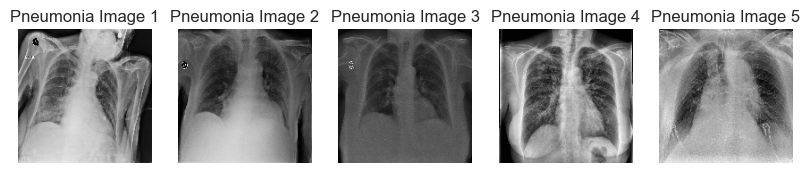

In [21]:
plot_images(class_0_indices, x_test, 'Pneumonia')

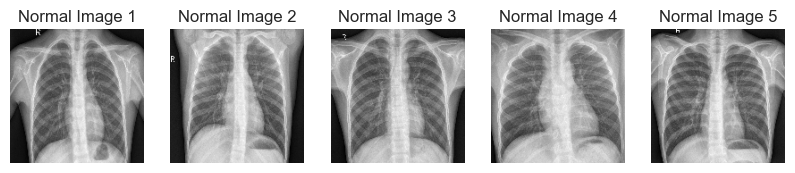

In [22]:
plot_images(class_1_indices, x_test, 'Normal')

## Saving Model

In [23]:
model.save('../saved/pretrained_pneumonia_cnn.h5')